In [1]:
## This version excludes CONTINUOUS Variables and the RFD variables AND _wHICH VARIABLES 3/27/2024 and con_max_consultorder_time/day and drg name
## 4/4/2024 Added QUINTILE variables
## 4/8/2024 Added QUINTILE varables by service
## 4/9/2024 Added more consult and imaging variables (e.g. ad,it order to consult order, admit order to imaging read)
## 4/11/2024 Added QUINTILE variables by service for the additional variables
# 06/12/2024: Added gender, added imaging_order_before_consult_order and consult_order_before_imaging order variables, excluded 290 patients in 2022, dropped raw race/insurance categories
# 06/14/2024: Removed quintiles
# 06/20/2024: Set seed for reproducibility
# 06/22/2024: Added sample size for validation
# 07/05/2024: Collapsed Cardiology into Medicine
# 07/08/2024: Added labels
# 07/25/2024: Removed duplicated patients from master file
# 08/01/2024: Changed XGBoost hyperparmeter tuning to Haipeng's code and using only one model

In [71]:
import pandas as pd
import numpy as np

#ML packages
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from feature_engine.discretisation import DecisionTreeDiscretiser
from sklearn.model_selection import GroupShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.calibration import calibration_curve

#XGBo
#https://github.com/liannewriting/YouTube-videos-public/blob/main/xgboost-python-tutorial-example/xgboost_python.ipynb
import xgboost as xgb
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
#hyperparameter values
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#Feature Selection
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.encoding import OneHotEncoder
from feature_engine.selection import DropFeatures, DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.imputation import AddMissingIndicator
from feature_engine.outliers import Winsorizer
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder

#Plotting Packages
import shap
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from hyperopt import tpe
from hyperopt import fmin, tpe, Trials
from hyperopt import STATUS_OK
from hyperopt import hp
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [3]:
def map_med (value):
    if value in ["Cardiology", "Medicine"]:
        return "Medicine"
    else:
        return value

### Filtering for specific patients

In [4]:
df_all = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/LOS/data/master_los.csv', index_col=[0])

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df_all.shape

(12771, 907)

In [7]:
df_all["viz_service_collapsed"] = df_all["viz_service_collapsed"].apply(map_med)

In [8]:
df_all["viz_service_collapsed"].value_counts()

viz_service_collapsed
Medicine             11481
Neurology              876
Surgical Services      414
Name: count, dtype: int64

In [9]:
#Filter for home patients
df_filt = df_all.copy()
#df_filt = df_all[df_all["viz_disp_collapsed"] == "Home"].copy()
#df_filt = df_all[df_all["thro_boarding_yn"] == 1].copy()

In [10]:
df_filt.shape

(12771, 907)

In [11]:
features_los = pd.read_excel('/gpfs/milgram/project/rtaylor/imc33/LOS/data/features_los_simple.xlsx')

# Features that are divided into 5 types to conduct data preprocessing
# 1. drop: features that need to be dropped
drop_list = features_los[features_los['type'] == 'drop']['col_name'].tolist()

# 2. category: features that are already categorical and need to be OneHotEncoding (add missing value indicator, impute missing by adding 'missing' category)
category_list = features_los[features_los['type'] == 'category']['col_name'].tolist()

# 3. binary: features that are binary and need to be converted to categorical (add missing value indicator / prefer: fill missing with 0)
binary_list = features_los[features_los['type'] == 'binary']['col_name'].tolist()

# 4. continuous: features that are continous/numerical variables, need outlier handling and normalization (add missing value indicator, fill missing with median)
continuous_list = features_los[features_los['type'] == 'continuous']['col_name'].tolist()

# 5. discrete: features that are discrete/numerical variables, need to be discretized (fill missing with 0)
discrete_list = features_los[features_los['type'] == 'discrete']['col_name'].tolist()

In [12]:
# Split into X, y
X = df_filt.drop(['viz_outcome_prolonged_los_yn'], axis=1)
y = df_filt['viz_outcome_prolonged_los_yn']

In [13]:
# Convert variables to categorical
#X[binary_list] = X[binary_list].astype('category')
X[category_list] = X[category_list].astype('category')

In [14]:
continuous_list.remove("viz_age")

In [ ]:
#Check drop list
#drop_list

In [15]:
X = X.drop(columns=drop_list+continuous_list)
X = X.reset_index()
y = y.reset_index()

In [16]:
# Split the data by group shuffle split on 'PAT_MRN_ID' into train set and validation set
gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

train_ix, val_ix = next(gss.split(X, y, groups=X['pat_mrn_id']))

X_train = X.loc[train_ix]
y_train = y.loc[train_ix]

X_val = X.loc[val_ix]
y_val = y.loc[val_ix]

# Drop 'PAT_MRN_ID' and set 'PAT_ENC_CSN_ID' as index
X_train = X_train.drop(['pat_mrn_id'], axis=1).set_index('pat_enc_csn_id')
X_val = X_val.drop(['pat_mrn_id'], axis=1).set_index('pat_enc_csn_id')
y_train = y_train.set_index('pat_enc_csn_id')
y_val = y_val.set_index('pat_enc_csn_id')

In [18]:
# Update feature preprocessing pipeline
feature_preprocess_pipeline = Pipeline(steps=[

    # Missing value imputation
    # Impute missing values with 0 for discrete variables
    ('arbitrary_number_imputer', ArbitraryNumberImputer(arbitrary_number=0, variables=discrete_list)),

    #Update 08/01/2024. Replaced CategoricalImputer with ArbitraryNumberInputer for Binary variables (1/0)
    # Impute missing values with 0 for binary variables 
    ('binary_imputer', ArbitraryNumberImputer(arbitrary_number=0, variables=binary_list)),
    
    # Impute missing values with adding 'missing' category for categorical variables 
   ('categorical_imputer', CategoricalImputer(variables=category_list)),
    
    # Rare encoding for categorical variables
    ('rare_label_encoder', RareLabelEncoder(tol=0.01, n_categories=5, max_n_categories=10, variables=category_list)),

    # OneHotEncoding for categoricals
    ('one_hot_category', OneHotEncoder(variables=category_list)),
    
])  # Apply the pipeline

In [19]:
# Apply the pipeline
X_train_preprocessed = feature_preprocess_pipeline.fit_transform(X_train, y_train)
X_val_preprocessed = feature_preprocess_pipeline.transform(X_val)

### Feature Selection

In [22]:
# 1st Feature Selection pipeline
feature_selection_pipeline = Pipeline(steps=[

        ('drop_constant', DropConstantFeatures(tol=0.99)),

        ('drop_duplicates', DropDuplicateFeatures()),

        ('correlated_features', SmartCorrelatedSelection(
        method='pearson',
        threshold=0.9,
        selection_method='model_performance',
        estimator=xgb.XGBClassifier(random_state=0)
        ))
])

### XGB Model

In [23]:
# Apply the pipeline
X_train_selected = feature_selection_pipeline.fit_transform(X_train_preprocessed, y_train)
X_val_selected = feature_selection_pipeline.transform(X_val_preprocessed)

In [24]:
X_train_selected.shape

(10246, 210)

In [25]:
y_train['viz_outcome_prolonged_los_yn'].sum()/y_train.shape[0]

0.4388053874682803

In [26]:
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [ ]:
#X_train_selected.to_csv("../data/pipeline/X_train_selected.csv", index=False)

In [ ]:
#X_train_selected2 = pd.read_csv("../data/pipeline/X_train_selected.csv")

In [27]:
# Choose best hyperparameters
def objective_function_xgb_1b(params, X_train, y_train):
    clf = xgb.XGBClassifier(**params)
    auc_scorer = make_scorer(roc_auc_score)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc', error_score='raise').mean()
    return {'loss': -score, 'status': STATUS_OK}

space_xgb= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': hp.choice('max_depth', np.arange(5, 15+1, dtype=int)),
    'n_estimators': hp.choice('n_estimators', np.arange(5, 35+1, dtype=int)),
    'num_leaves': hp.choice('num_leaves', np.arange(5, 50+1, dtype=int)),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

def run_xgb_tune_fit_1b(X_train, y_train, num_eval):
    trials = Trials()
    best_params = fmin(fn=lambda params: objective_function_xgb_1b(params, X_train, y_train),
                       space=space_xgb, algo=tpe.suggest, verbose=4, max_evals=num_eval, trials=trials,
                       rstate= np.random.default_rng(0))

    best_params['max_depth'] = list(np.arange(5, 15+1, dtype=int))[best_params['max_depth']]
    best_params['n_estimators'] = list(np.arange(5, 35+1, dtype=int))[best_params['n_estimators']]
    best_params['num_leaves'] = list(np.arange(5, 50+1, dtype=int))[best_params['num_leaves']]
    
    best_xgb_model = xgb.XGBClassifier(**best_params)
    print(f"XGB Best parameters for {len(X_train.columns)} features: {best_params}")
    best_xgb_model.fit(X_train, y_train)
    return best_xgb_model

In [28]:
# Evaluate model performance including auc, accuracy, etc
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, probabilities)
    accuracy = accuracy_score(y_test, predictions)

    fpr, tpr, _ = roc_curve(y_test, probabilities)
    precision, recall, _ = precision_recall_curve(y_test, probabilities)
    pr_auc_score = auc(recall, precision)

    return {
        'y_test': y_test,
        'predictions': predictions,
        'probabilities': probabilities,
        'auc_score': auc_score,
        'accuracy': accuracy,
        'fpr': fpr,
        'tpr': tpr,
        'precision': precision,
        'recall': recall,
        'pr_auc_score': pr_auc_score
    }


In [29]:
model_xgb = run_xgb_tune_fit_1b(X_train_selected, y_train, num_eval=20)

100%|██████████| 20/20 [00:15<00:00,  1.30trial/s, best loss: -0.7480289006034617]
XGB Best parameters for 210 features: {'colsample_by_tree': 0.6425936901635491, 'learning_rate': 0.13914887471932533, 'max_depth': 14, 'n_estimators': 29, 'num_leaves': 35, 'reg_lambda': 0.8474645439246081}


In [33]:
results = evaluate_model(model_xgb, X_val_selected, y_val)

In [ ]:
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8, verbosity=1))
]

tuning_pipeline = Pipeline(steps=estimators)

In [ ]:
search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

model_xgb = BayesSearchCV(tuning_pipeline, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8) 

In [ ]:
y_train = y_train.set_index('pat_enc_csn_id')

In [ ]:
model_xgb.fit(X_train_selected,  y_train)

In [31]:
#model_xgb.best_estimator_

In [32]:
#model_xgb.best_score_

In [ ]:
#y_val = y_val.set_index('pat_enc_csn_id')

In [ ]:
#Column 1 and Column 2 are the probabilities that the label is 0 or 1 
y_probs = model_xgb.predict_proba(X_val_selected)
y_pred = model_xgb.predict(X_val_selected)
#Only select the positive class
y_probs_positive = y_probs[:,1]
y_test = y_val

In [50]:

def plot_metrics(data):
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))  # 3 rows x 1 column

    # Plot ROC Curve
    y_test = data['y_test']
    y_probs_positive = data['probabilities']
    fpr, tpr, _ = roc_curve(y_test, y_probs_positive)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend()

    # Plot PR Curve
    precision, recall, _ = precision_recall_curve(y_test, y_probs_positive)
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('PR Curve')
    axes[1].legend()

    # Plot Calibration Curve
    prob_true, prob_pred = calibration_curve(y_test, y_probs_positive, n_bins=10)
    axes[2].plot(prob_pred, prob_true, label='Calibration')
    axes[2].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
    axes[2].set_xlabel('Mean Predicted Probability')
    axes[2].set_ylabel('Fraction of Positives')
    axes[2].set_title('Calibration Curve')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


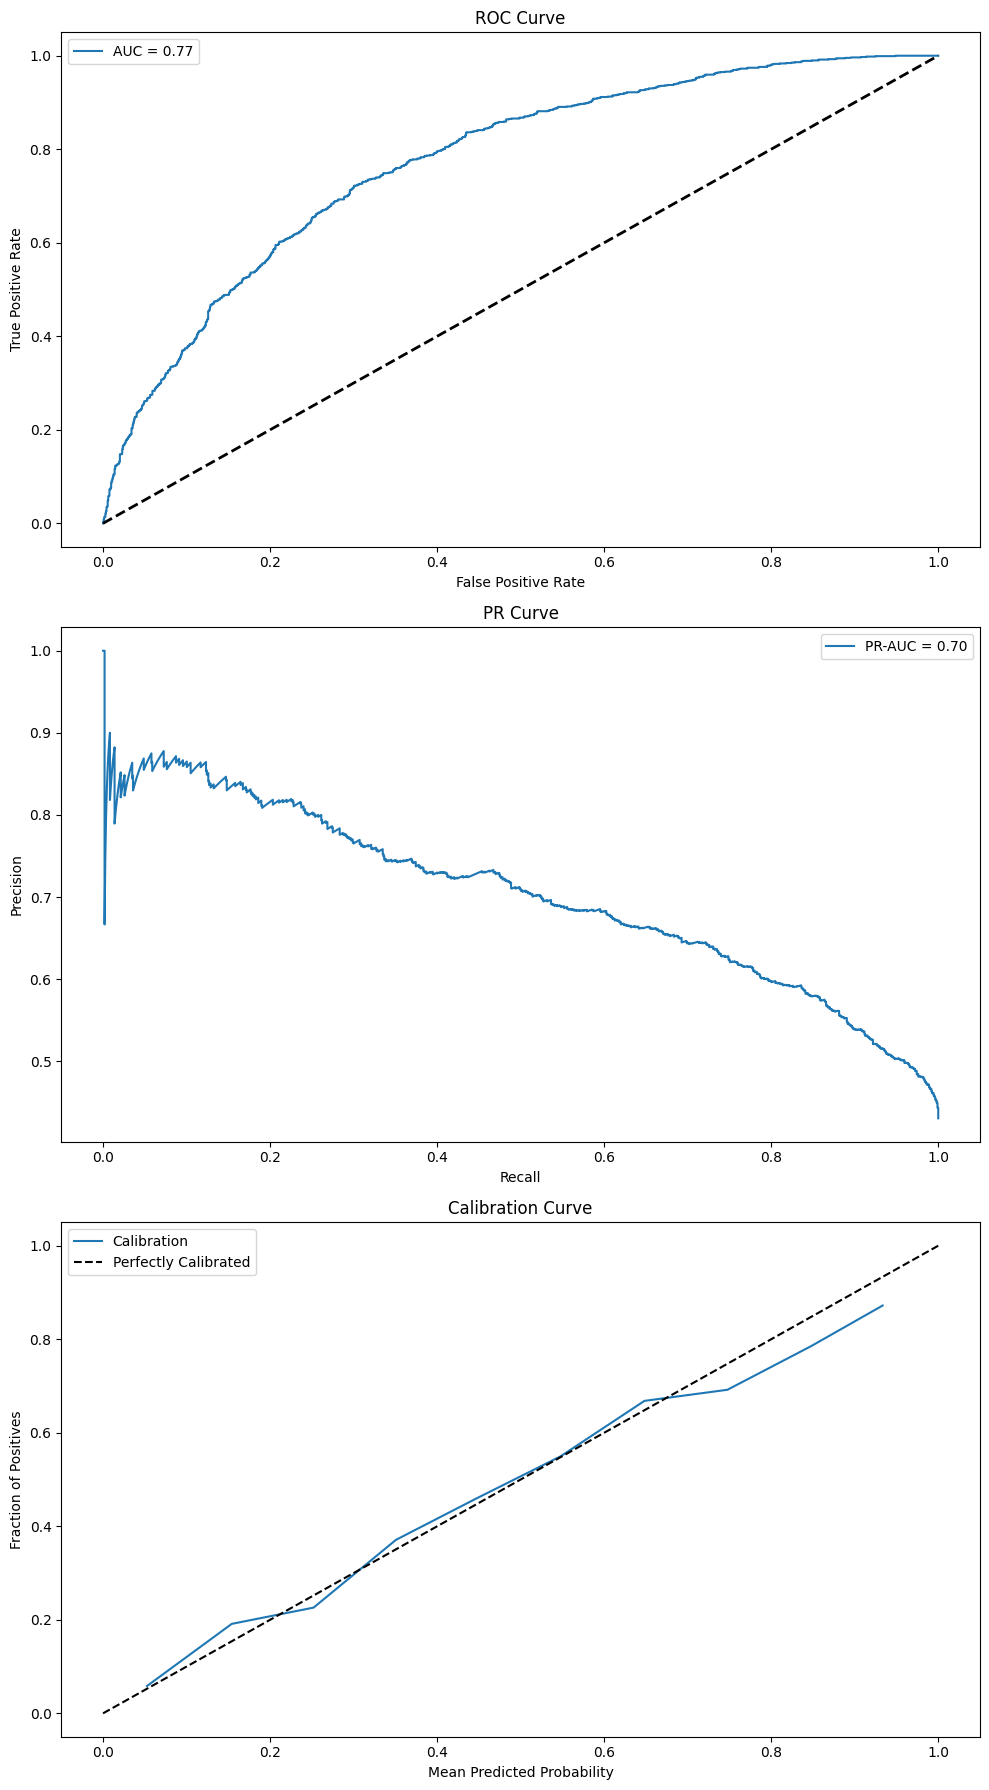

In [51]:
plot_metrics(results)

In [57]:
results['y_test']

,viz_outcome_prolonged_los_yn
pat_enc_csn_id,
308895811,0
308903557,0
308902970,0
308908148,0
308894616,0
...,...
343784937,0
343750343,0
343875134,0


In [58]:

def plot_cm(data):
     
    y_test = data['y_test']['viz_outcome_prolonged_los_yn']
    y_pred = data['predictions']
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Extract values for binary classification
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    
    # Calculate metrics
    top_row = tn + fp
    bot_row = fn + tp
    
    specificity_value = recall_score(y_test, y_pred, pos_label=0)
    sensitivity_value = recall_score(y_test, y_pred, pos_label=1)
    accuracy_value = accuracy_score(y_test, y_pred)
    precision_value = precision_score(y_test, y_pred)
    f1_value = f1_score(y_test, y_pred)
    
    # Print results
    print(f'Specificity : {specificity_value:.4f}')
    print(f'Sensitivity : {sensitivity_value:.4f}')
    print(f'Accuracy : {accuracy_value:.4f}')
    print(f'Precision : {precision_value:.4f}')
    print(f'F1 score : {f1_value:.4f}')
    
    print(f'Of {top_row} people who did not have a prolonged LOS, {tn} ({specificity_value:.2%}) were correctly classified.')
    print(f'Of {bot_row} people who did have a prolonged LOS, {tp} ({sensitivity_value:.2%}) were correctly classified.')



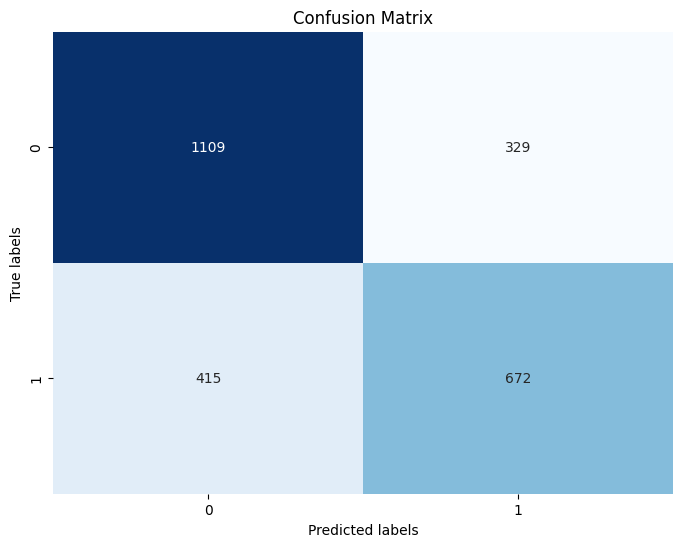

Specificity : 0.7712
Sensitivity : 0.6182
Accuracy : 0.7053
Precision : 0.6713
F1 score : 0.6437
Of 1438 people who did not have a prolonged LOS, 1109 (77.12%) were correctly classified.
Of 1087 people who did have a prolonged LOS, 672 (61.82%) were correctly classified.


In [61]:
plot_cm(results)

### SHAP plots

In [ ]:
#model_xgb.best_estimator_.steps

In [ ]:
#train_fp = '/gpfs/milgram/project/rtaylor/imc33/LOS/data/pipeline/los_train_initial_selected.csv'
val_fp = '/gpfs/milgram/project/rtaylor/imc33/LOS/data/pipeline/los_val_initial_selected.csv'

#X_train_selected.to_csv(train_fp)
X_val_selected.to_csv(val_fp)

#X_train_selected = pd.read_csv(train_fp, index_col=[0])
X_val_selected = pd.read_csv(val_fp, index_col=[0])

In [ ]:
X_val_selected

In [62]:
X_val_selected.shape

(2525, 210)

In [63]:
# Set seeds for reproducibility
np.random.seed(42)

In [ ]:
#clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
#clf_xgb.fit(X_train_selected, 
#            y_train['viz_outcome_prolonged_los_yn'], 
#            verbose=True,
#            early_stopping_rounds=10,
 #           eval_metric='aucpr',
 #           eval_set=[(X_val_selected, y_val['viz_outcome_prolonged_los_yn'])])

[10]	validation_0-aucpr:0.68671


[11]	validation_0-aucpr:0.68744


[12]	validation_0-aucpr:0.68992


[13]	validation_0-aucpr:0.68632


[14]	validation_0-aucpr:0.68898


[15]	validation_0-aucpr:0.69074


[16]	validation_0-aucpr:0.69288


[17]	validation_0-aucpr:0.69528


[18]	validation_0-aucpr:0.69456


[19]	validation_0-aucpr:0.69547


[20]	validation_0-aucpr:0.69445


[21]	validation_0-aucpr:0.69480


[22]	validation_0-aucpr:0.69706


[23]	validation_0-aucpr:0.69670


[24]	validation_0-aucpr:0.69591


[25]	validation_0-aucpr:0.69511


[26]	validation_0-aucpr:0.69566


[27]	validation_0-aucpr:0.69852


[28]	validation_0-aucpr:0.70046


[29]	validation_0-aucpr:0.70005


[30]	validation_0-aucpr:0.70008


[31]	validation_0-aucpr:0.70400


[32]	validation_0-aucpr:0.70462


[33]	validation_0-aucpr:0.70599


[34]	validation_0-aucpr:0.70649


[35]	validation_0-aucpr:0.70616


[36]	validation_0-aucpr:0.70824


[37]	validation_0-aucpr:0.70944


[38]	validation_0-aucpr:0.70880


[39]	validation_0-aucpr:0.71118


[40]	validation_0-aucpr:0.71096


[41]	validation_0-aucpr:0.70930


[42]	validation_0-aucpr:0.70917


[43]	validation_0-aucpr:0.71076


[44]	validation_0-aucpr:0.71089


[45]	validation_0-aucpr:0.71149

[46]	validation_0-aucpr:0.71215


[47]	validation_0-aucpr:0.71441

[48]	validation_0-aucpr:0.71532

[49]	validation_0-aucpr:0.71697


[50]	validation_0-aucpr:0.71773

[51]	validation_0-aucpr:0.71607

[52]	validation_0-aucpr:0.71716


[53]	validation_0-aucpr:0.71760


[54]	validation_0-aucpr:0.71844


[55]	validation_0-aucpr:0.71874


[56]	validation_0-aucpr:0.71882


[57]	validation_0-aucpr:0.71888

[58]	validation_0-aucpr:0.72018


[59]	validation_0-aucpr:0.72128


[60]	validation_0-aucpr:0.72103


[61]	validation_0-aucpr:0.72035

[62]	validation_0-aucpr:0.72050


[63]	validation_0-aucpr:0.72036


[64]	validation_0-aucpr:0.72106


[65]	validation_0-aucpr:0.72106


[66]	validation_0-aucpr:0.72089


[67]	validation_0-aucpr:0.72054


[68]	validation_0-aucpr:0.72019


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=None, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
X_val_selected

In [ ]:
model_xgb

In [ ]:
X_val_selected

In [64]:
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_val_selected)

In [ ]:
X_val_selected

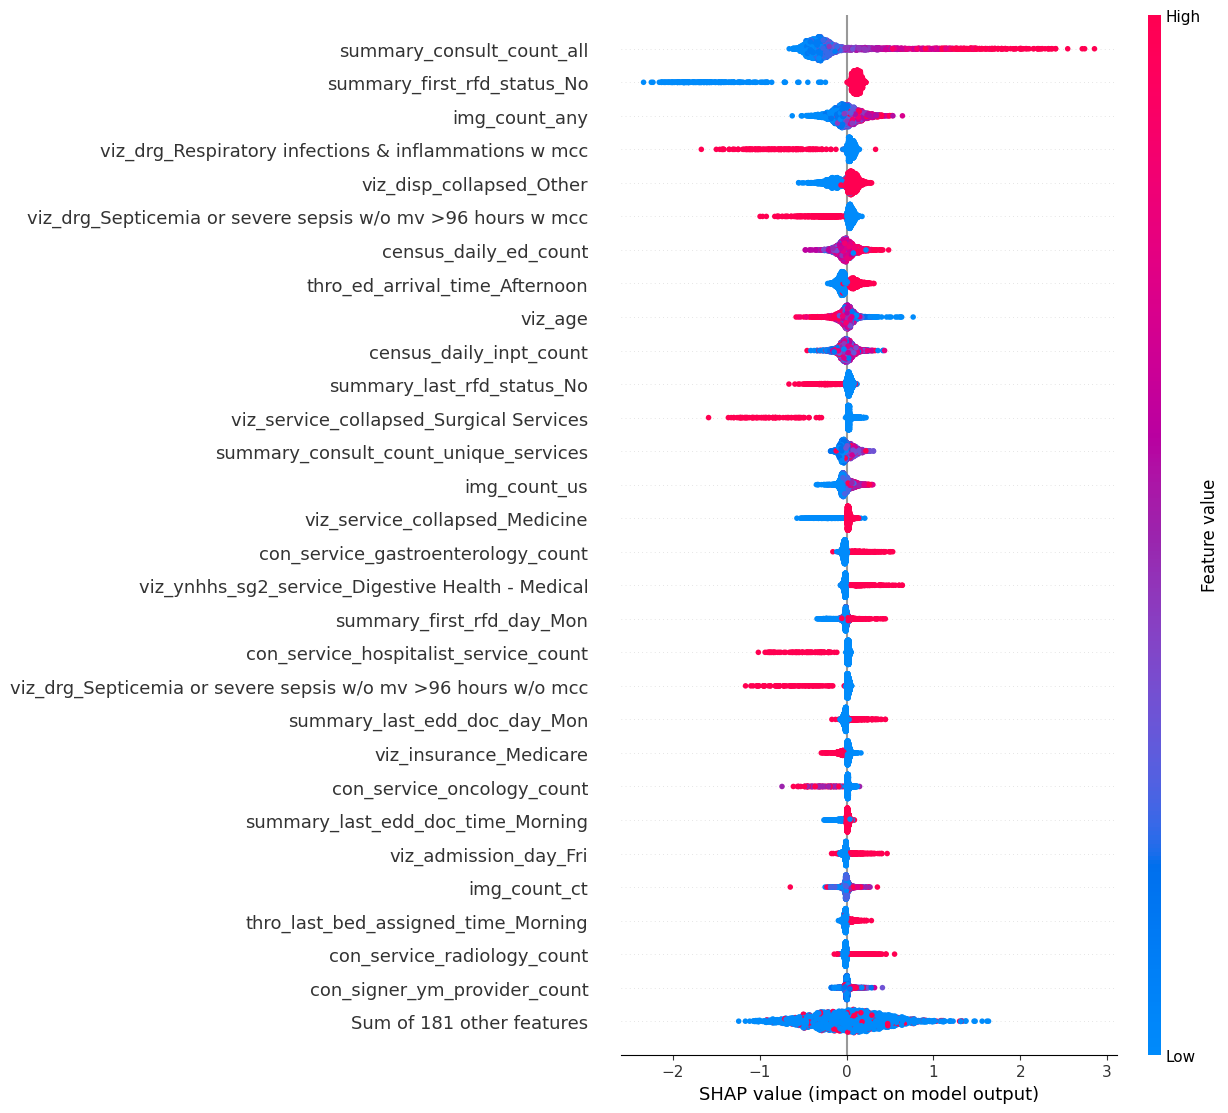

In [65]:
shap.plots.beeswarm(shap_values, max_display=30)

In [66]:
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)

In [67]:
mean_abs_shap = np.abs(shap_df).mean(axis=0)

In [68]:
top_30_features = mean_abs_shap.sort_values(ascending=False).head(30)


In [69]:
for feature in top_30_features.index.tolist():
    print(feature)

summary_consult_count_all
summary_first_rfd_status_No
img_count_any
viz_drg_Respiratory infections & inflammations w mcc
viz_disp_collapsed_Other
viz_drg_Septicemia or severe sepsis w/o mv >96 hours w mcc
census_daily_ed_count
thro_ed_arrival_time_Afternoon
viz_age
census_daily_inpt_count
summary_last_rfd_status_No
viz_service_collapsed_Surgical Services
summary_consult_count_unique_services
img_count_us
viz_service_collapsed_Medicine
con_service_gastroenterology_count
viz_ynhhs_sg2_service_Digestive Health - Medical
summary_first_rfd_day_Mon
con_service_hospitalist_service_count
viz_drg_Septicemia or severe sepsis w/o mv >96 hours w/o mcc
summary_last_edd_doc_day_Mon
viz_insurance_Medicare
con_service_oncology_count
summary_last_edd_doc_time_Morning
viz_admission_day_Fri
img_count_ct
thro_last_bed_assigned_time_Morning
con_service_radiology_count
con_signer_ym_provider_count
viz_discharged_day_Tue


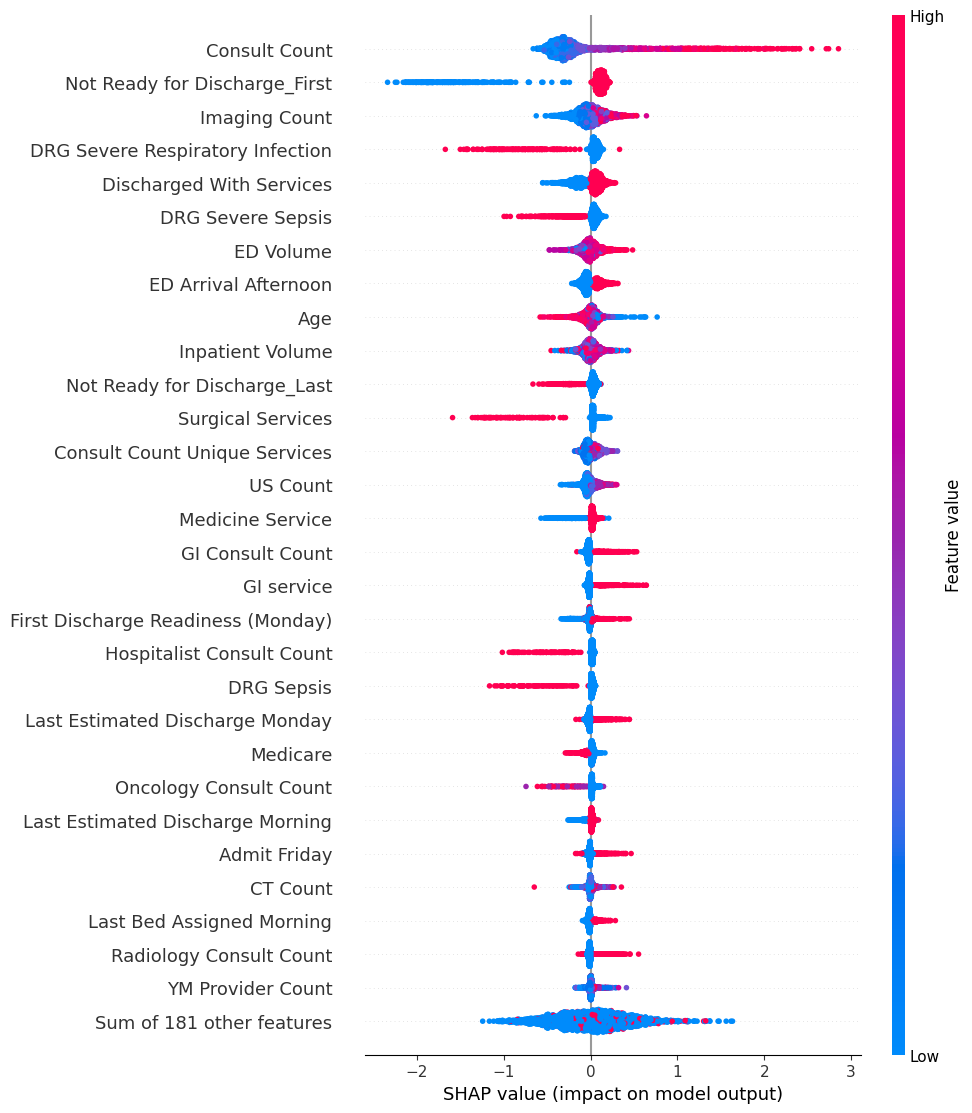

In [70]:
lab_df = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/LOS/data/new_label_names.csv')

new_feature_names_dict = pd.Series(lab_df.new_name.values, index=lab_df.old_name).to_dict()

current_feature_names = shap_values.feature_names  # Current feature names

# Update feature names in the SHAP values object
new_feature_names = [new_feature_names_dict.get(name, name) for name in current_feature_names]
shap_values.feature_names = new_feature_names

# Generate the beeswarm plot with the updated feature names
shap.plots.beeswarm(shap_values, max_display=30)